# Data preparation

This notebook investigates Collective2 strategies data and describes a basic data cleaning and preparation.

Collective2 database contains many "kinds" of strategies: live, dead, autotraded, papertraded, TOS strategies, tests, crashed, outliers, tests of imports from brokers, strategies not supported by developers, C2 stuff tests, private systems...

We need to clean up the data as much as possible.

## Strategies selection

A basic selection is made per Matthew Klein's instructions described here: https://collective2.slack.com/archives/CH97NLREC/p1602264235225600

Strategies are selected using that receipe. Equities are selected just in times when strategies are live. It helps to prevent errors based on "looking to the future". Selected equities are stored in the separate database table.

### Equities
Stored equities table has a usual structure: SystemId, DateTime, TotalPL.
Collective2 account equities ere calculated in irregular time intervals.
So equities are conveted to daily data. Each missing day is filled by the last previous value from C2 equity table.
Commissions are subtracted from equities. Subscriptions fees are NOT subtracted in ther research.
If TotalPL is zero or negative, the strategy is considered as dead and equity data are ended here. It means we do not have a negative equities in the table.

We can use a query like this to see future returns for each date:

```
select 
     eq.Systemid,
     eq.datetime as DateStart,
     eq.totalpl as Equity,
     
     # --------- Values 30 days after DateStart -----------
     adddate(eq.datetime, INTERVAL 030 Day) as DateEnd030, 
     eq30.totalpl as Equity030, 
     (eq30.totalpl / eq.totalpl - 1 ) as Return030     
     from c2ex_equity_daily eq 
     left join c2ex_equity_daily eq30 on eq.systemid=eq30.systemid and eq30.Datetime = adddate(eq.Datetime, INTERVAL 30 DAY) 
     order by eq.datetime, eq.Systemid;
```

Example: Let's see how it works for the system 117723809.

`select from_unixtime(startsecs),from_unixtime(endsecs) from providerCreditsPackages where systemid = 117723809;`

A result is: 
from_unixtime(startsecs) = '2018-04-30 15:16:39'
from_unixtime(endsecs) = '2020-06-01 03:04:50'

So the trade leader paid for system between 2018-04-30 and 2020-06-01.

However, the following query
`select from_unixtime(effective_kill_time) from systems_killed_soft where systemid = 117723809;`
returns this result: 2020-05-16 09:35:19

It means Collective2 marked this system as (soft) killed already on 2020-05-16 due an inactivity.

Let's see what we receive from the equity table in this case:

In [26]:
source("JupyterUtils.R")

sql= "select 
     eq.datetime as DateStart,
     eq.totalpl as Equity,
     
     # --------- Values 7 days after DateStart -----------
     adddate(eq.datetime, INTERVAL 007 Day) as DateEnd007, 
     eq7.totalpl as Equity007, 
     (eq7.totalpl / eq.totalpl - 1 ) as Return007,

     # --------- Values 14 days after DateStart -----------
     adddate(eq.datetime, INTERVAL 014 Day) as DateEnd014, 
     eq14.totalpl as Equity014, 
     (eq14.totalpl / eq.totalpl - 1 ) as Return014

     from c2ex_equity_daily eq 
     left join c2ex_equity_daily eq7 on eq.systemid=eq7.systemid and eq7.Datetime = adddate(eq.Datetime, INTERVAL 7 DAY) 
     left join c2ex_equity_daily eq14 on eq.systemid=eq14.systemid and eq14.Datetime = adddate(eq.Datetime, INTERVAL 14 DAY)  
     
     where eq.Systemid = 117723809
     
     order by eq.datetime;"

dbData = getC2ScoreDbData(sql)
cat("A data example of the system 117723809\n")
head(dbData)
tail(dbData,n=20)

A data example of the system 117723809


,DateStart,Equity,DateEnd007,Equity007,Return007,DateEnd014,Equity014,Return014
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,2018-04-30 00:00:00,15000,2018-05-07 00:00:00,15718,0.047867,2018-05-14 00:00:00,16279,0.085267
2,2018-05-01 00:00:00,15000,2018-05-08 00:00:00,15631,0.042067,2018-05-15 00:00:00,15895,0.059667
3,2018-05-02 00:00:00,15000,2018-05-09 00:00:00,15907,0.060467,2018-05-16 00:00:00,16016,0.067733
4,2018-05-03 00:00:00,15152,2018-05-10 00:00:00,16154,0.066130,2018-05-17 00:00:00,16012,0.056758
5,2018-05-04 00:00:00,15742,2018-05-11 00:00:00,16141,0.025346,2018-05-18 00:00:00,15902,0.010164
6,2018-05-05 00:00:00,15742,2018-05-12 00:00:00,16141,0.025346,2018-05-19 00:00:00,15902,0.010164


,DateStart,Equity,DateEnd007,Equity007,Return007,DateEnd014,Equity014,Return014
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
730,2020-04-28 00:00:00,19179.6,2020-05-05 00:00:00,19151.6,-0.001460,2020-05-12 00:00:00,19101.6,-0.004067
731,2020-04-29 00:00:00,19125.6,2020-05-06 00:00:00,19163.6,0.001987,2020-05-13 00:00:00,19124.6,-0.000052
732,2020-04-30 00:00:00,19161.6,2020-05-07 00:00:00,19136.6,-0.001305,2020-05-14 00:00:00,19104.6,-0.002975
733,2020-05-01 00:00:00,19264.6,2020-05-08 00:00:00,19107.6,-0.008150,2020-05-15 00:00:00,19099.6,-0.008565
734,2020-05-02 00:00:00,19264.6,2020-05-09 00:00:00,19107.6,-0.008150,2020-05-16 00:00:00,19098.6,-0.008617
735,2020-05-03 00:00:00,19264.6,2020-05-10 00:00:00,19107.6,-0.008150,2020-05-17 00:00:00,0.0,-1.000000
736,2020-05-04 00:00:00,19237.6,2020-05-11 00:00:00,19103.6,-0.006966,2020-05-18 00:00:00,NA,NA
737,2020-05-05 00:00:00,19151.6,2020-05-12 00:00:00,19101.6,-0.002611,2020-05-19 00:00:00,NA,NA
738,2020-05-06 00:00:00,19163.6,2020-05-13 00:00:00,19124.6,-0.002035,2020-05-20 00:00:00,NA,NA


We see equity data since 2018-04-30 in the first table.
And we see the latest data for this system in the second table.
The latest data are from 2020-05-16 which is the date the system was softly killed.

Columns: 
- DateStart is an equity date.
- Equity is the current date equity value.
- DateEnd007 is a date after 7 days.
- Equity007 is an equity value after 7 days.
- Return007 is an equity return between the current date and after 7 days.

Similarly DateEnd014, Equity014 and Return014 columns are values 14 days after the current date.

We can see that 7 days and 14 days returns are NA (NULL) after the date the system was killed.

A query like this is a base for backtests. 
We can select a set of systems using some criteria like `Sharpe > 2` or `SystemAge > 30` and compare results of such set with results of other systems set or the whole population of systems in the future. 

`NA` values in the future mean that the system died meantime. It's equity is zero and return is calculated as -100% in stats. 
(But this lead to the very skewed data distribution and this value was not used later.) 

A query like above is stored as a view named `SystemsReturnsInIntervals` in the database. It is a foundation of all SQL queries.

In [11]:
# We can use the SystemsReturnsInIntervals view for basic statistics calculations.
# For example: lets calculate descriptive stats of 30 days returns of all systems for each day

cat("Let's see a couple of rows from 2020. Last 30 rows are not defined in this case. Let's skip last 25 of them.\n")

sql = str_interp("
    select 
    Date(DateStart) as Date, 
    count(*) as Systems, 

    Date(DateEnd030) as DateEnd030, 
    min(Return030) as minRet030, 
    max(Return030) as maxRet030, 
    count(Return030) as countRet030, 
    avg(Return030) as avgRet030, 
    std(Return030) as stdRet030

    from SystemsReturnsInIntervals 
    where DateStart >= '2020-01-01'
    group by Date(DateStart) order by DateStart;")

dbData = getC2ScoreDbData(sql)
head(dbData)
rows = nrow(dbData)
dbData[(rows-35):(rows-25),]

Let's see a couple of rows from 2020. Last 30 rows are not defined in this case. Let's skip last 25 of them.


,Date,Systems,DateEnd030,minRet030,maxRet030,countRet030,avgRet030,stdRet030
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-01-01,670,2020-01-31,-1.000000,1.364021,565,0.013076611,0.1792090
2,2020-01-02,673,2020-02-01,-1.000000,1.364188,569,0.003315325,0.1698530
3,2020-01-03,678,2020-02-02,-0.632796,1.339768,566,0.014830359,0.1391318
4,2020-01-04,672,2020-02-03,-1.000000,1.474050,567,0.013325194,0.1701306
5,2020-01-05,672,2020-02-04,-1.000000,1.439386,567,0.014918409,0.1880667
6,2020-01-06,677,2020-02-05,-1.000000,1.779367,566,0.021092122,0.1888022


,Date,Systems,DateEnd030,minRet030,maxRet030,countRet030,avgRet030,stdRet030
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
430,2021-03-05,743,2021-04-04,-0.883054,15.081093,635,0.05532418,0.6236712
431,2021-03-06,740,2021-04-05,-0.895887,2.449265,623,0.03766735,0.1899603
432,2021-03-07,734,2021-04-06,-0.896288,2.449265,608,0.04533285,0.1930793
433,2021-03-08,737,2021-04-07,-0.894387,2.444783,593,0.04563631,0.1986920
434,2021-03-09,742,2021-04-08,-0.869472,2.683797,586,0.02936940,0.2038836
435,2021-03-10,740,2021-04-09,-0.869871,2.482313,575,0.02137332,0.1992101
436,2021-03-11,746,2021-04-10,NA,NA,0,NA,NA
437,2021-03-12,747,2021-04-11,NA,NA,0,NA,NA
438,2021-03-13,743,2021-04-12,NA,NA,0,NA,NA


We can see that 30-days returns are not available at the end of the database (last 30 days). We need to remember that when calculating stats and investigating data. 

The above results show some interesting things:
- There are some outliers there. Max 30-days returns like 136% can't be correct.
- Minimal return -1.0 (which is -100%) are strategies which died.
- Counts of systems are less after 30-days (see countRet030). Their difference tells us how many systems died within 30 days.

## Collective2 systems population evolution

Let's look at our data from the bird's eye view.

In [32]:
# What is a number of paid systems from the start of Collective until today:
sql = "select count(distinct(systemid)) as Count, 
       Date(min(datetime)) as Start, 
       Date(max(datetime)) as End 
       from c2ex_equity_daily"
dbData = getC2ScoreDbData(sql)

cat("\nWe have",dbData$Count,"paid systems in the database from",dbData$Start, "to", dbData$End,".\n")


We have 6692 paid systems in the database from 2005-02-17 to 2021-04-09 .



A chart of daily systems counts from 2005-02-17 to 2021-04-04 :


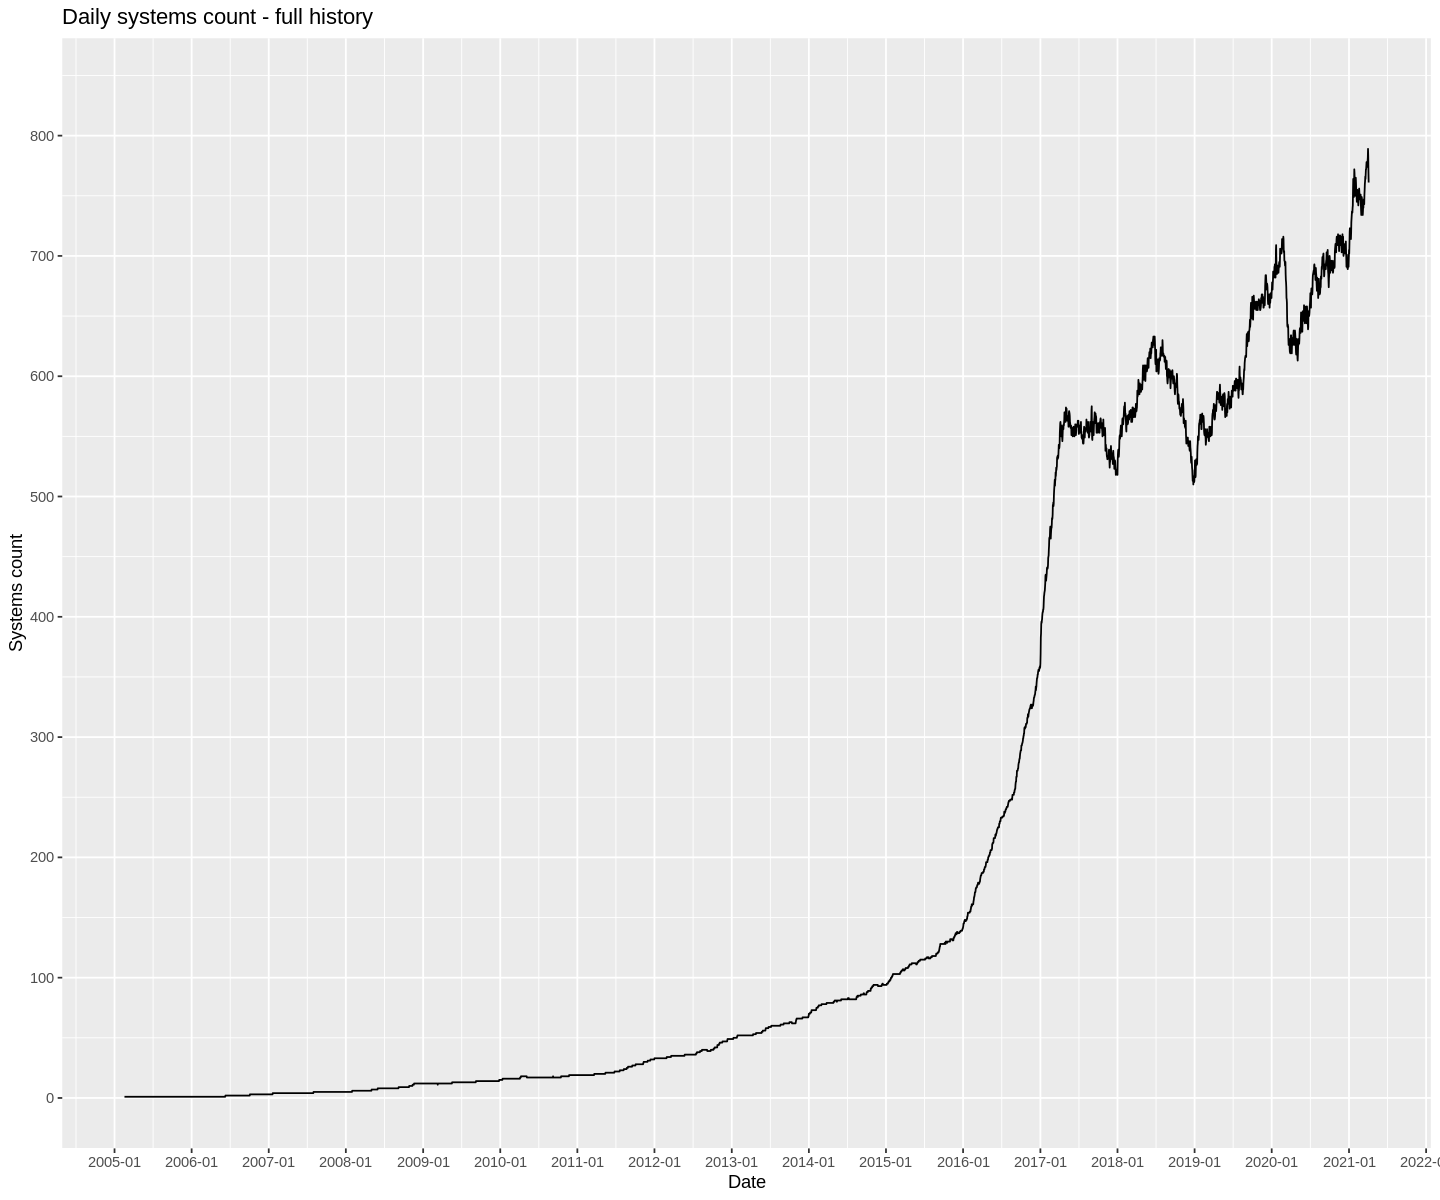

In [35]:

# Lets visualize systems numbers

# Omit last 5 days. (Some strategies may not yet be calculated.)
sql = "select * from (
            select  Date(Datetime) as Date, 
            count(distinct(systemid)) as SystemsCount
            from c2ex_equity_daily 
            group by Date(Datetime) 
            order by Date DESC limit 5, 100000) sub  
        order by Date ASC"

datesAndSystems = getC2ScoreDbData(sql)

cat("\nA chart of daily systems counts from",datesAndSystems$Date[1],"to", datesAndSystems$Date[nrow(datesAndSystems)],":\n")

datesAndSystems$Dates = as.Date(datesAndSystems$Date)
ggplot(datesAndSystems, aes(x=Dates, y=SystemsCount)) + 
      ggtitle("Daily systems count - full history") + 
      geom_line() + 
      xlab("Date") + 
      scale_x_date(date_labels = "%Y-%m",date_breaks = "1 year") + 
      scale_y_continuous(name= "Systems count", limits=c(0, max(datesAndSystems$SystemsCount)+50), breaks=seq(0,1000,100))

We can see two very different phases there. A phase from 2005 to 2017 and a phase from 2017 until now.

The first phase is very, very different from the second one. It contains small numbers of systems, but it lasts for 12 years. It creates its own universe. 

While a number of systems is small, we have a very large number of **observations** in this 12 years long phase. The number of **observations** affects overall statistics. The question is, if this phase has any meaning today. 

The chart shows that Collective2 changed substantially over time. Collective2 changed its "character" and it's first phase is gone forever.

It seems that data describing a **current** Collective2 state start around 06/2017.


A chart of daily systems counts from 2017-06-01 to 2021-04-04 :


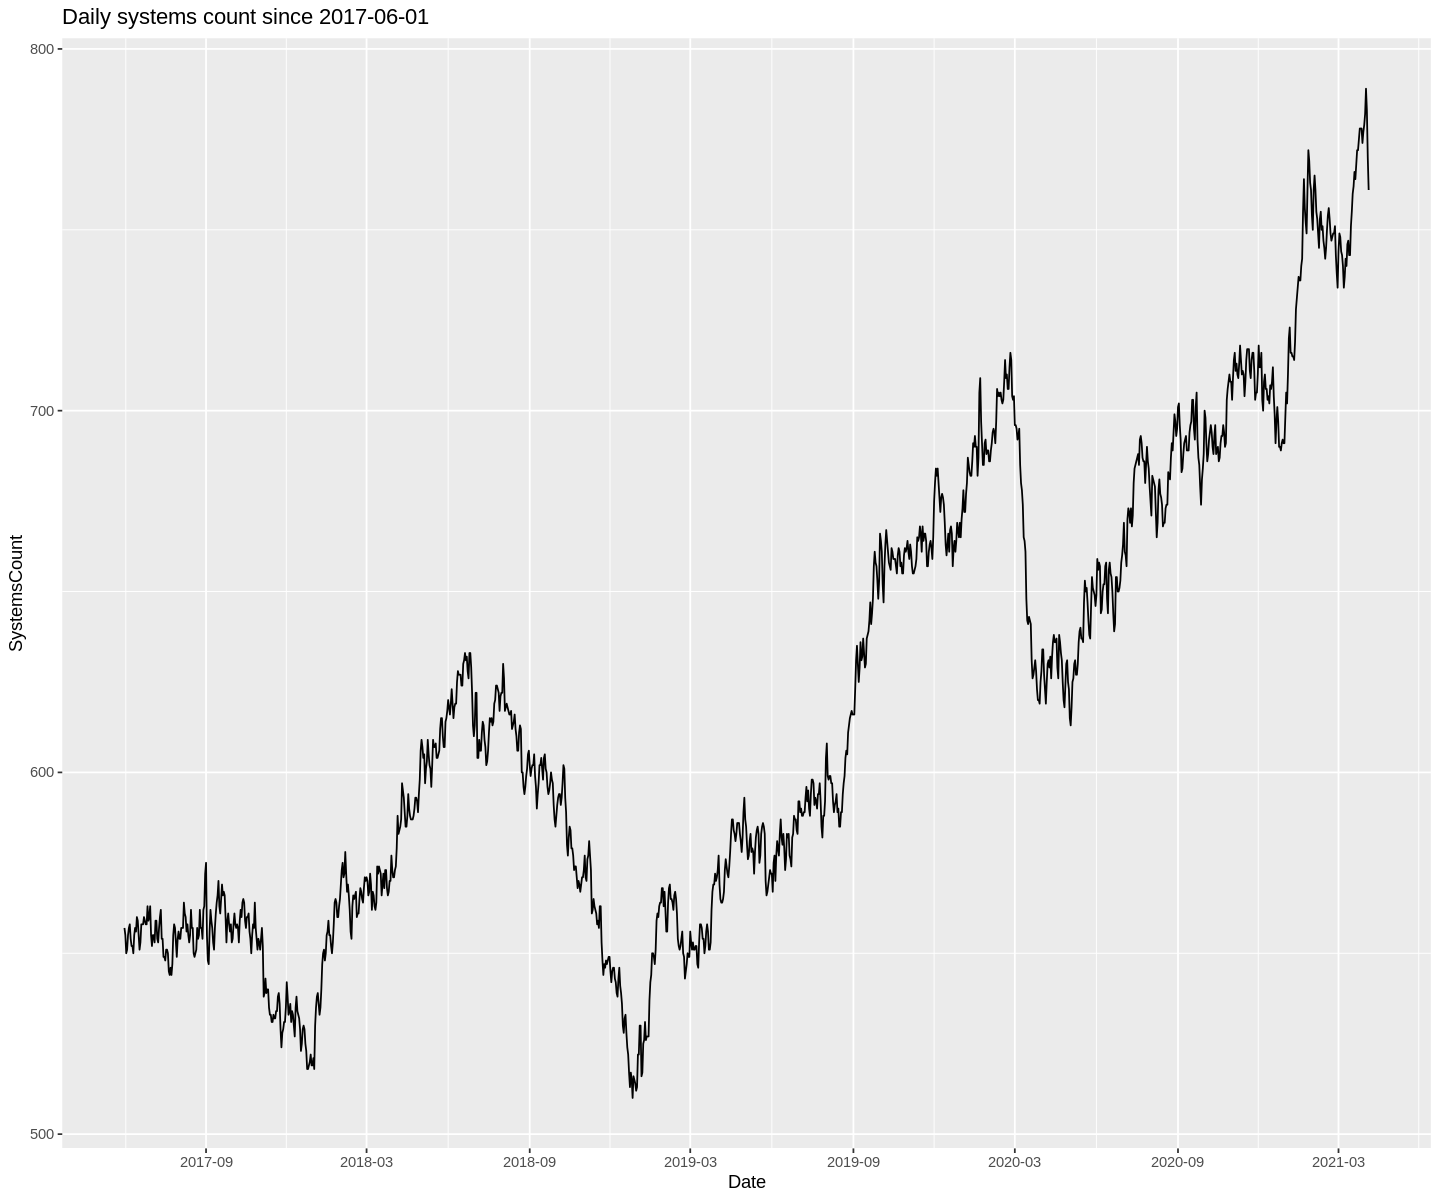

In [37]:

# Let's visualize just data since '2017-06-01'

# Omit last 5 days. (Some strategies may not yet be calculated.)
sql = "select * from (
            select  Date(Datetime) as Date, 
            count(distinct(systemid)) as SystemsCount
            from c2ex_equity_daily 
            where Date(datetime) >= '2017-06-01'
            group by Date(Datetime) 
            order by Date DESC limit 5, 100000) sub  
        order by Date ASC"

datesAndSystems = getC2ScoreDbData(sql)

cat("\nA chart of daily systems counts from",datesAndSystems$Date[1],"to", datesAndSystems$Date[nrow(datesAndSystems)],":\n")

datesAndSystems$Dates = as.Date(datesAndSystems$Date)

ggplot(datesAndSystems, aes(x=Dates, y=SystemsCount)) + 
      ggtitle("Daily systems count since 2017-06-01") + 
      geom_line() + 
      xlab("Date") + 
      scale_x_date(date_labels = "%Y-%m",date_breaks = "6 months")

## Cleaning

Observations: 701563 


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.00000 -0.02165  0.00045  0.01822  0.04728 93.56897 

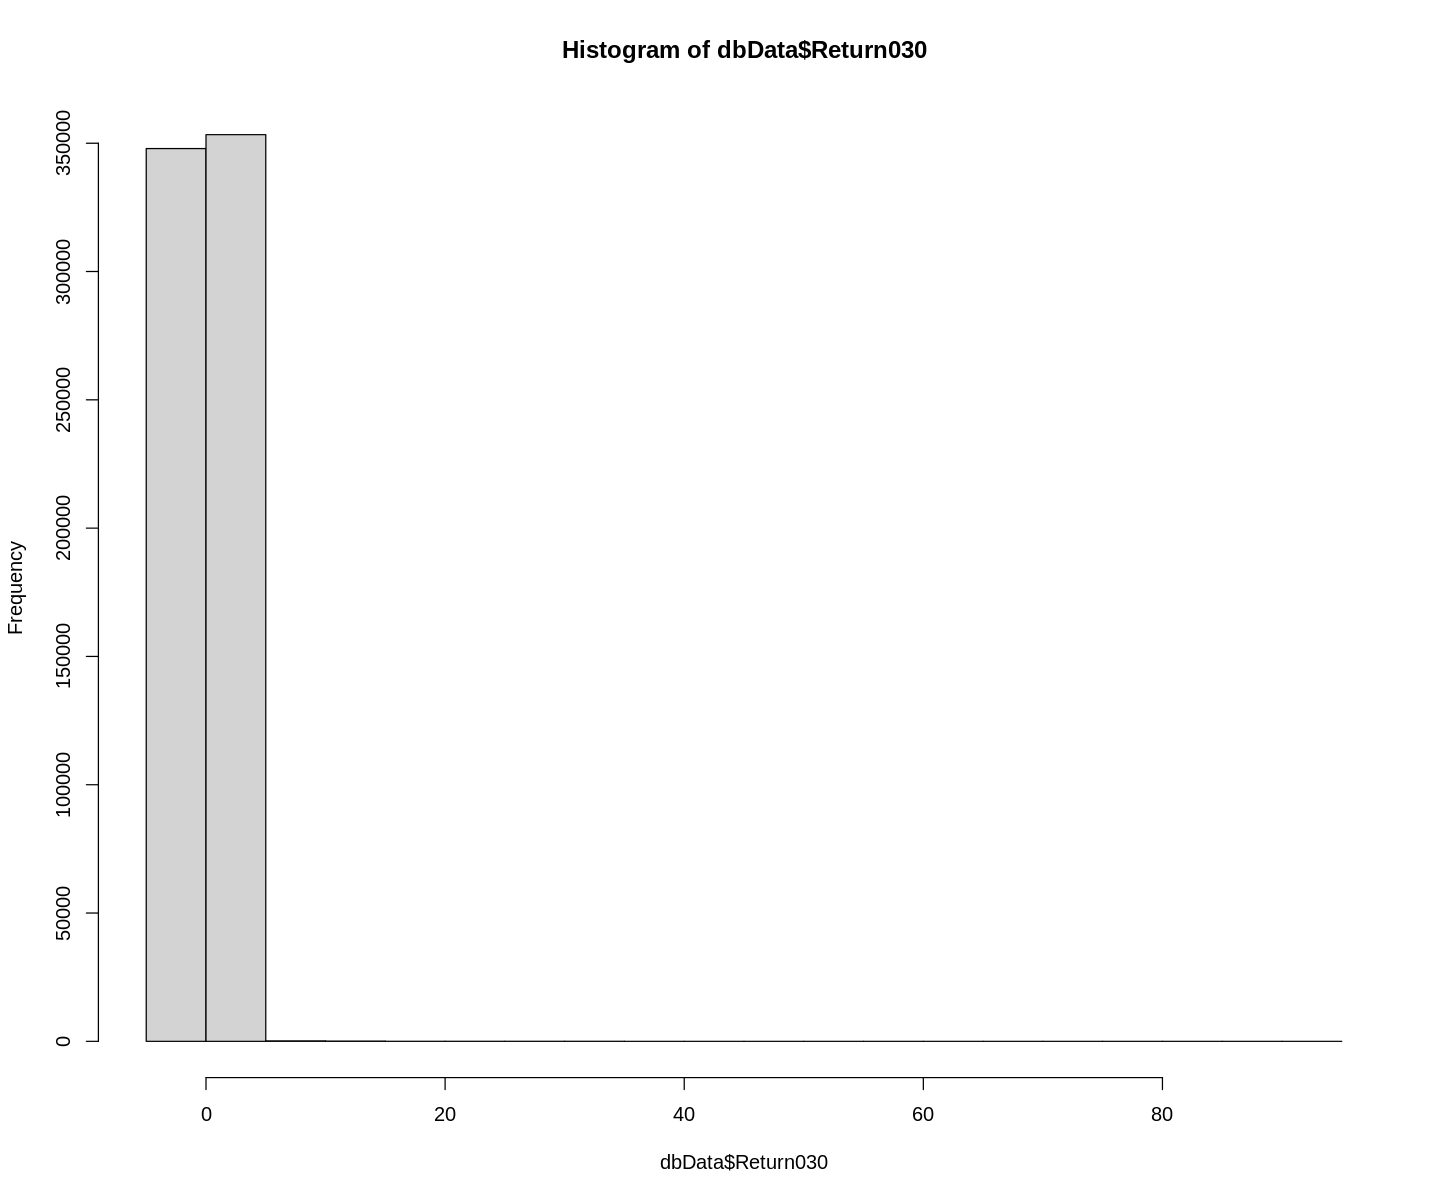

In [38]:
# We are going to investigate systems returns in this study. 
# Let's make a whole population stats of the 30-days returns to see what data we have in hands.
sql = "select Return030
       from SystemsReturnsInIntervals 
       where DateStart >= '2017-06-01' and Equity030 is not null ;"
dbData = getC2ScoreDbData(sql)    
cat("Observations:",nrow(dbData),"\n")
summary(dbData$Return030)
hist(dbData$Return030)

- Minimum -1.0 means -100%. It is OK. Some systems have lost everything. 

- But 30-days return higher than 100% can't be real. 

- We see Max is even much much higher there. It clearly must be a data error. 

We should clean our data. 


1-week returns > 50%:
Observations: 3691 = 0.4234862 % of all 871575 observations.


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.5005   0.6004   0.7747   1.4726   1.1692 121.8391 


2-weeks returns > 50%:
Observations: 5870 = 0.6734934 % of all 871575 observations.


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.5000   0.5995   0.7840   1.4300   1.2291 101.2888 

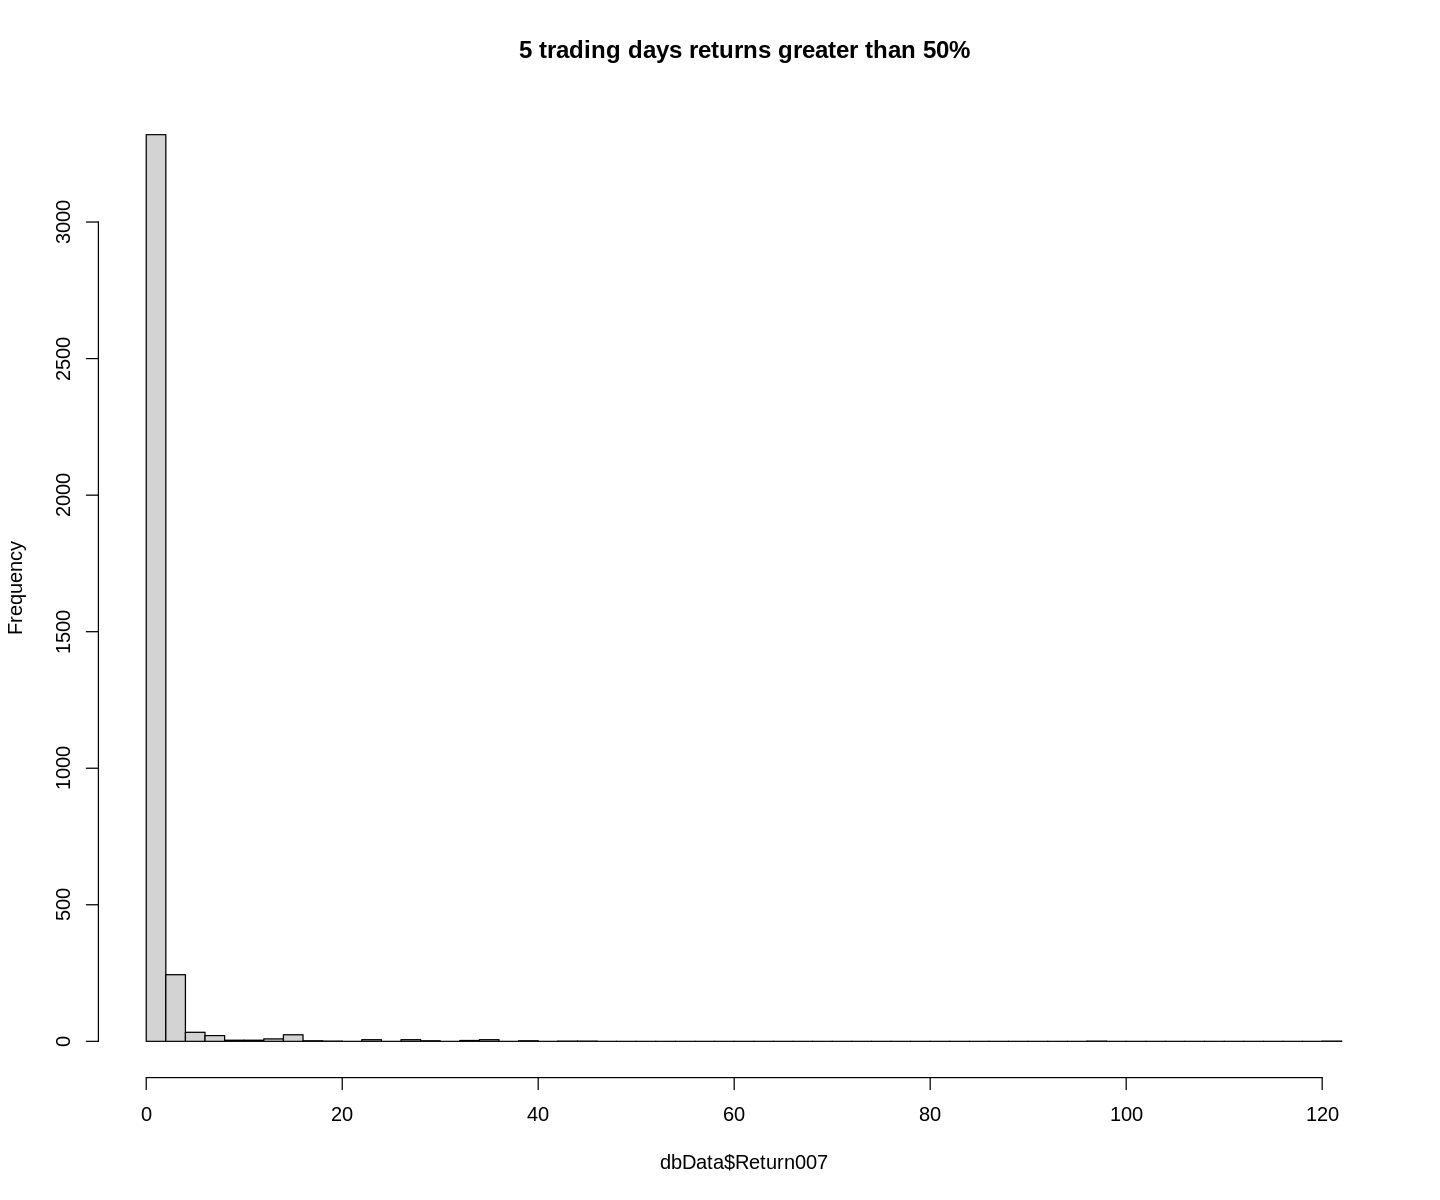

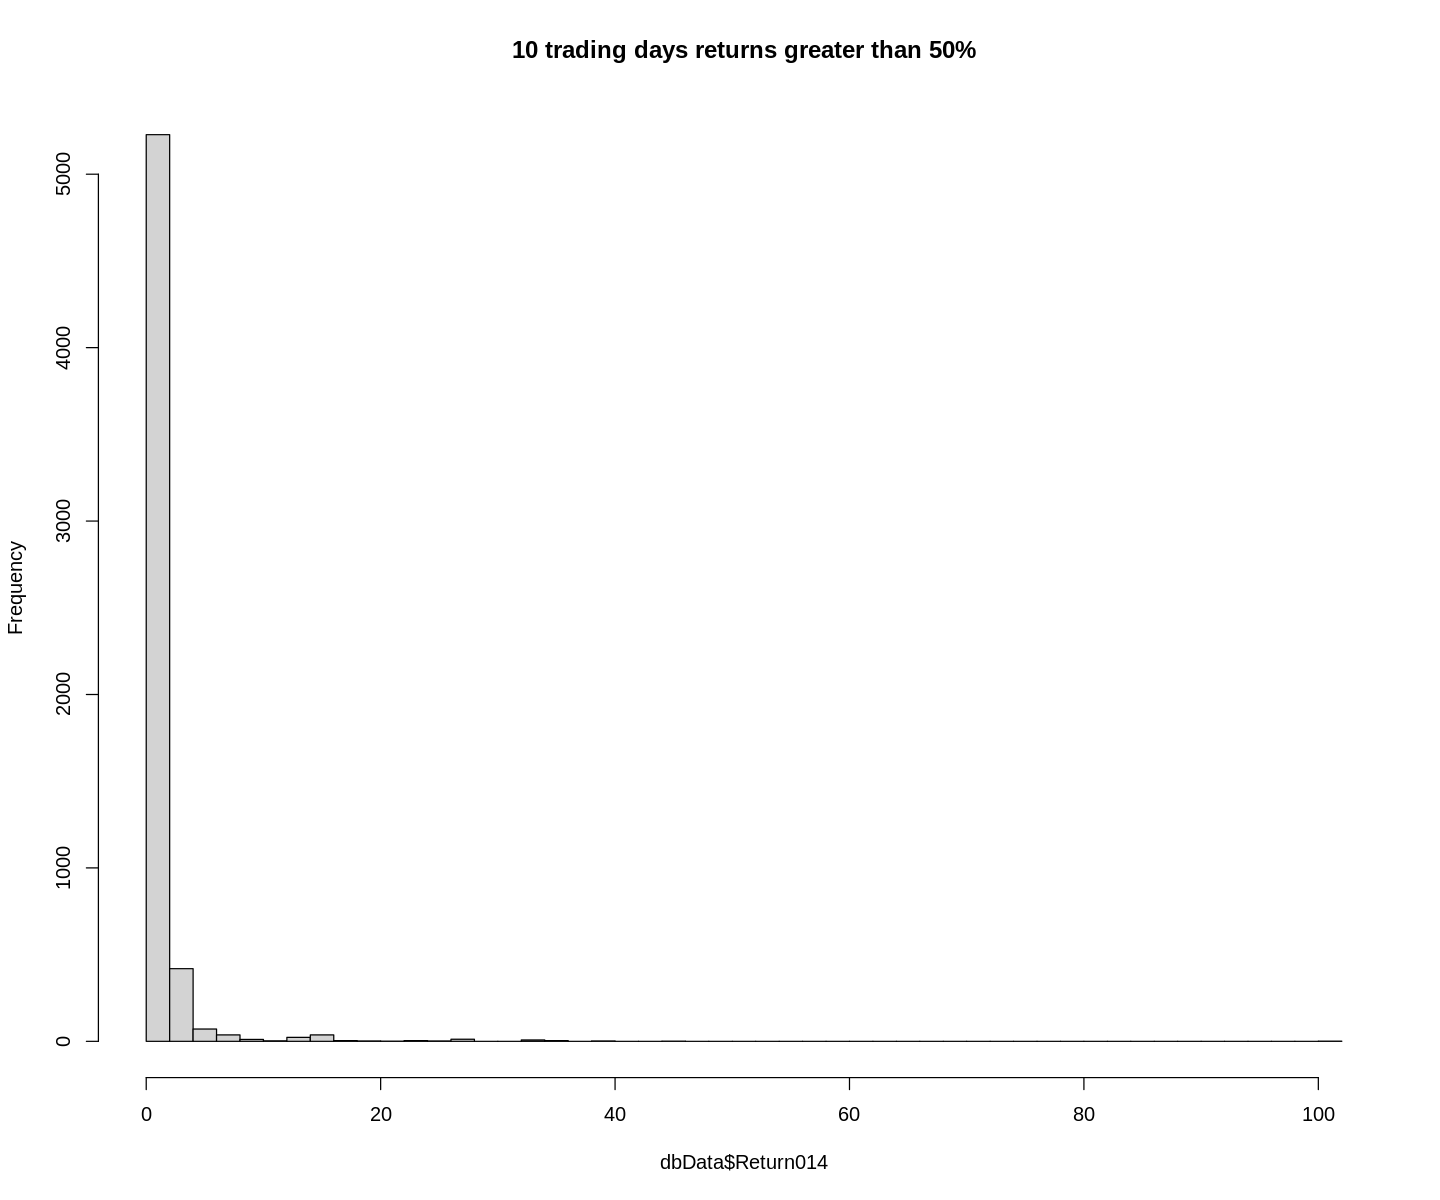

In [40]:
STARTING_DATE = '2017-06-01'
#STARTING_DATE = '2005-01-01'

# Get number of all observations for following calculations at first:
dbData = getC2ScoreDbData(str_interp("select * from SystemsReturnsInIntervals where Date(DateStart) >= '${STARTING_DATE}'"))    
OBSERVATIONS_FROM_STARTING_DATE = nrow(dbData) # store this for the future usage

# Let's look if such unreal returns happen even in the shorter time intervals like 7 and 14 days:

cat("\n1-week returns > 50%:\n")
sql = str_interp("select Return007 from SystemsReturnsInIntervals where Return007 > 0.5 and Date(DateStart) >= '${STARTING_DATE}'")
dbData = getC2ScoreDbData(sql)    
cat("Observations:",nrow(dbData),"=",100*nrow(dbData)/OBSERVATIONS_FROM_STARTING_DATE,"% of all",OBSERVATIONS_FROM_STARTING_DATE,"observations.\n")
summary(dbData$Return007)
hist(dbData$Return007,breaks=50,main="5 trading days returns greater than 50%")

cat("\n2-weeks returns > 50%:\n")
sql = str_interp("select Return014 from SystemsReturnsInIntervals where Return014 > 0.5 and Date(DateStart) >= '${STARTING_DATE}'")
dbData = getC2ScoreDbData(sql)    
cat("Observations:",nrow(dbData),"=",100*nrow(dbData)/OBSERVATIONS_FROM_STARTING_DATE,"% of all",OBSERVATIONS_FROM_STARTING_DATE,"observations.\n")
summary(dbData$Return014)
hist(dbData$Return014,breaks=50,main="10 trading days returns greater than 50%")


 Yes. There are unreal returns in time intervals like 7 and 14 days.
 Maybe some bitcoin systems or overleveraged systems can make 50% per 1-2 weeks. 
 But most likely, those returns are just data errors and we should remove them from our data. 
 Fortunately, the found errors counts are just small fractions of all observations. 
 It means a probability we do something very bad is small.
 So - for the sake of simplicity - lets exclude such systems from our data entirely.
 Please note that those returns are within 1-2 weeks. It is just 5 - 10 trading days for those extraordinary returns.
 We are not going to remove systems having the same returns within longer time intervals.
 
 Well, this is probably the hardest part of this study.
 Our data needs to be cleaned. We can't use data like 10,000% return.
 If we won't find a way how to clean our data, then all we get is just GIGO. :-( 

Similarly, we should exclude errors and outliers in losers.

For example systems making drawdowns greater than 50% within 5-10 working days.
It can be just an error in data, but such drawdowns are generaly possible too. 

So we should be careful and try to not skew data towards positive results. Let's just omit dead systems for now and show losers.

Maybe we could find a way how to recognize more data errors, but it will be hard.


1-week drawdowns > 50%:
Observations: 3382 = 0.3880332 % of all observations: 871575 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.9996 -0.7781 -0.6543 -0.6802 -0.5615 -0.5000 


2-weeks drawdowns > 50%:
Observations: 5095 = 0.5845739 % of all observations: 871575 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.9996 -0.7737 -0.6433 -0.6767 -0.5602 -0.5000 

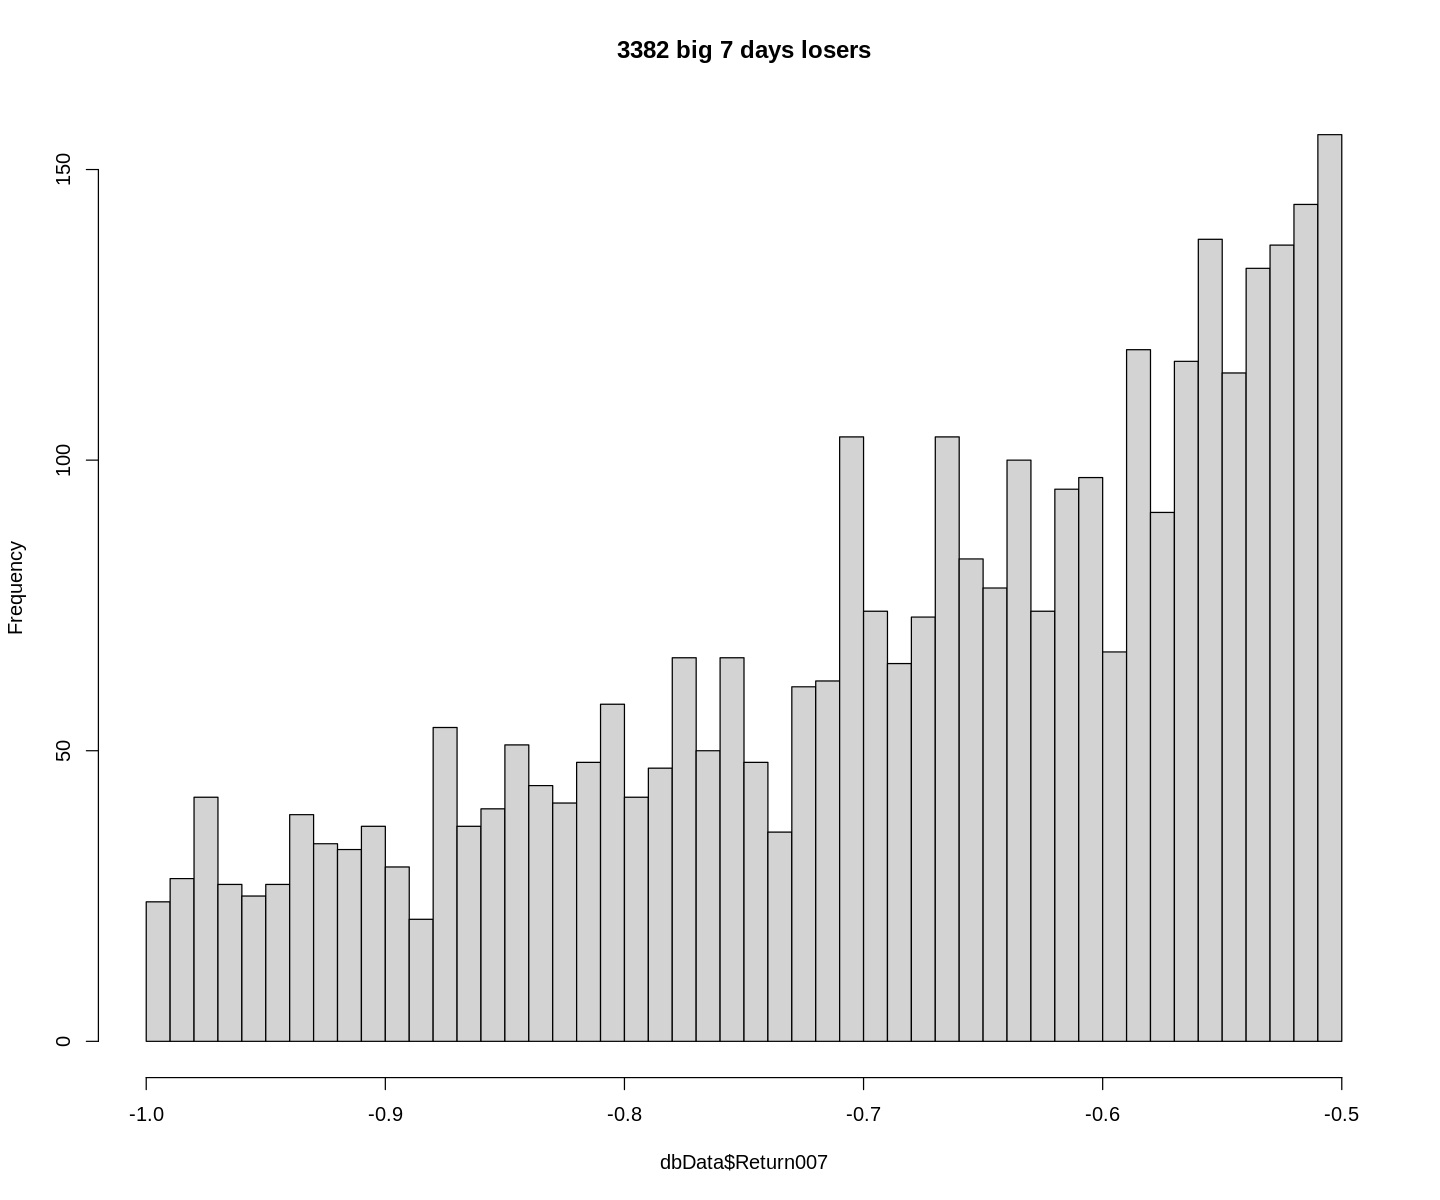

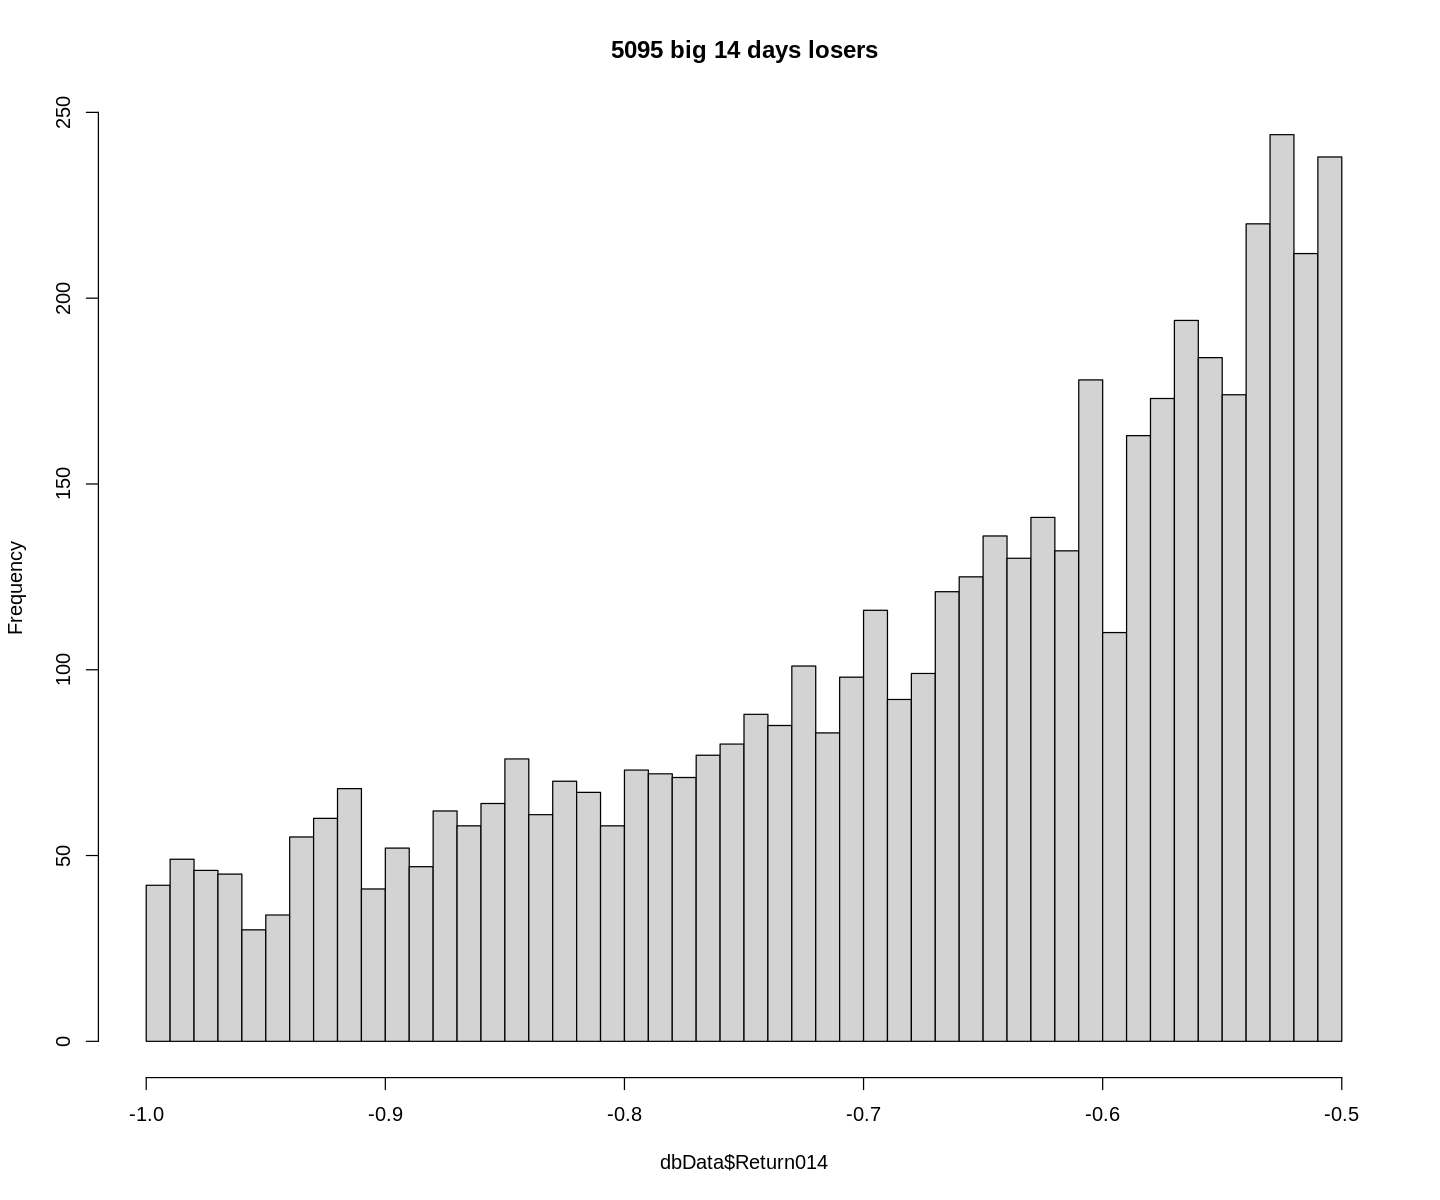

In [41]:
cat("\n1-week drawdowns > 50%:\n")
sql = str_interp("select Return007 from SystemsReturnsInIntervals 
       where Date(DateStart) >= '${STARTING_DATE}' 
             and (Return007 > -1 and Return007 < -0.5)")
dbData = getC2ScoreDbData(sql)  
cat("Observations:",nrow(dbData),"=",100*nrow(dbData)/OBSERVATIONS_FROM_STARTING_DATE,"% of all observations:",OBSERVATIONS_FROM_STARTING_DATE,"\n")
summary(dbData$Return007)
hist(dbData$Return007,breaks=50,main=paste0(nrow(dbData)," big 7 days losers"))

cat("\n2-weeks drawdowns > 50%:\n")
sql = str_interp("select Return014 from SystemsReturnsInIntervals 
        where Date(DateStart) >= '${STARTING_DATE}' 
              and (Return014 > -1 and Return014 < -0.5)")
dbData = getC2ScoreDbData(sql)    
cat("Observations:",nrow(dbData),"=",100*nrow(dbData)/OBSERVATIONS_FROM_STARTING_DATE,"% of all observations:",OBSERVATIONS_FROM_STARTING_DATE,"\n")
summary(dbData$Return014)
hist(dbData$Return014,breaks=50,main=paste0(nrow(dbData)," big 14 days losers"))

## Data errors

Well, it is not all...

There are data errors causing 1-2 days up and down spikes and various outliers which should be omitted from the data set too.

This is what I mean:

![Spike down](docs/Documentation/SpikeDown.png)
![Spike up](docs/Documentation/SpikeUp.png)
![Spike down - up](docs/Documentation/SpikeDownUp.png)
![Spike up - down](docs/Documentation/SpikeUpDown.png)

Looking at many systems, I ended with this "cleaner":

```
select Systemid
from SystemsReturnsShort
join c2systems on c2systems.guid = SystemsReturnsShort.systemid
where 
     # C2 glitch down or up within 1 - 3 days
     ( Return001 < -0.8 and ( (Return002 > -0.2 and Return002 < 0.2) or (Return003 > -0.2 and Return003 < 0.2) ) )
     or ( Return001 > 0.8 and ((Return002 > -0.2 and Return002 < 0.2) or (Return003 > -0.2 and Return003 < 0.2) ))
     # Sudden drop up or down greater than 100% - 130%
     or Return002 < -1.0
     or Return002 > 1.0      
     or Return003 < -1.0 
     or Return003 > 1.1      
     or Return004 > 1.2
     or Return005 > 1.3
     # more then 50% returns within 5 or 10 trading days
     or Return007 > 0.5
     or Return014 > 0.5;
```
#:: [The list of omitted systems is here](docs/Documentation/SystemsWithOutliersOmitted.html).

[The list of omitted systems is here](https://svancara.github.io/C2ScoringWorkbench/Documentation/SystemsWithOutliersOmitted.html).


The problem is, that this filter filters systems trading options. Such systems have wild equtity curves. So yes, we will lose some systems, but I believe that positives of this filtering outweights negatives. We can fix this later, in separated study, using just systems trading options.

## Cleaned data


Observations: 557219 


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-1.000000 -0.018959  0.000200  0.001986  0.040280  0.944394 

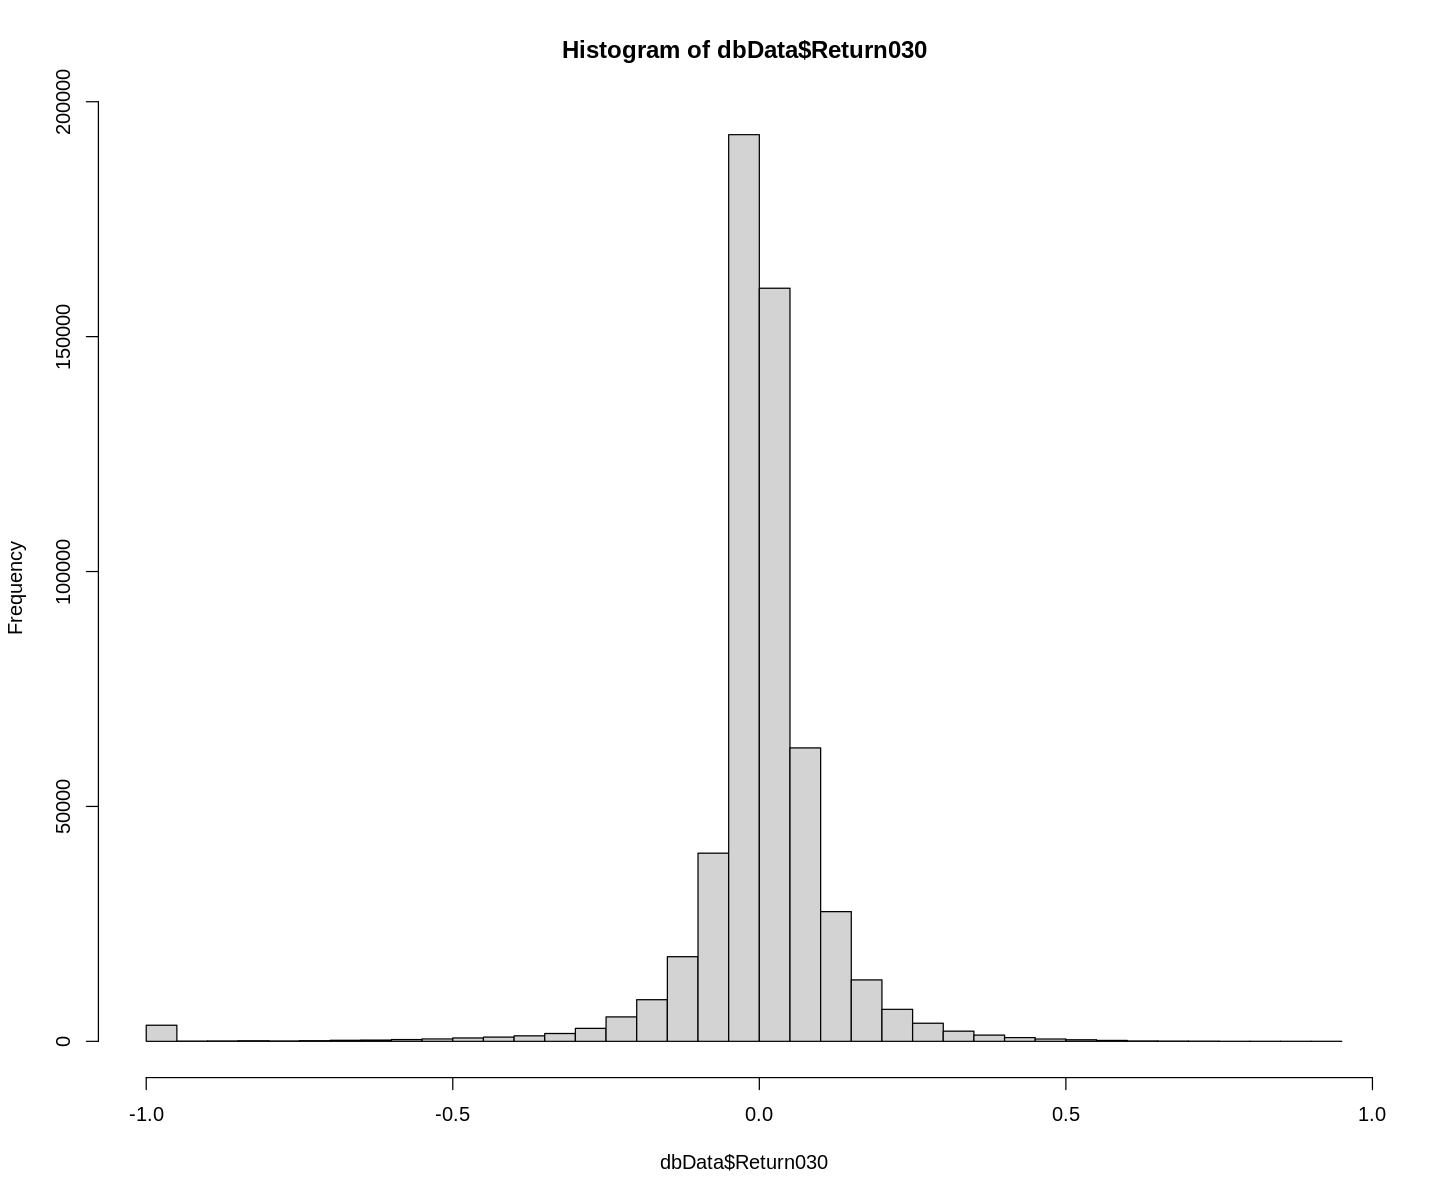

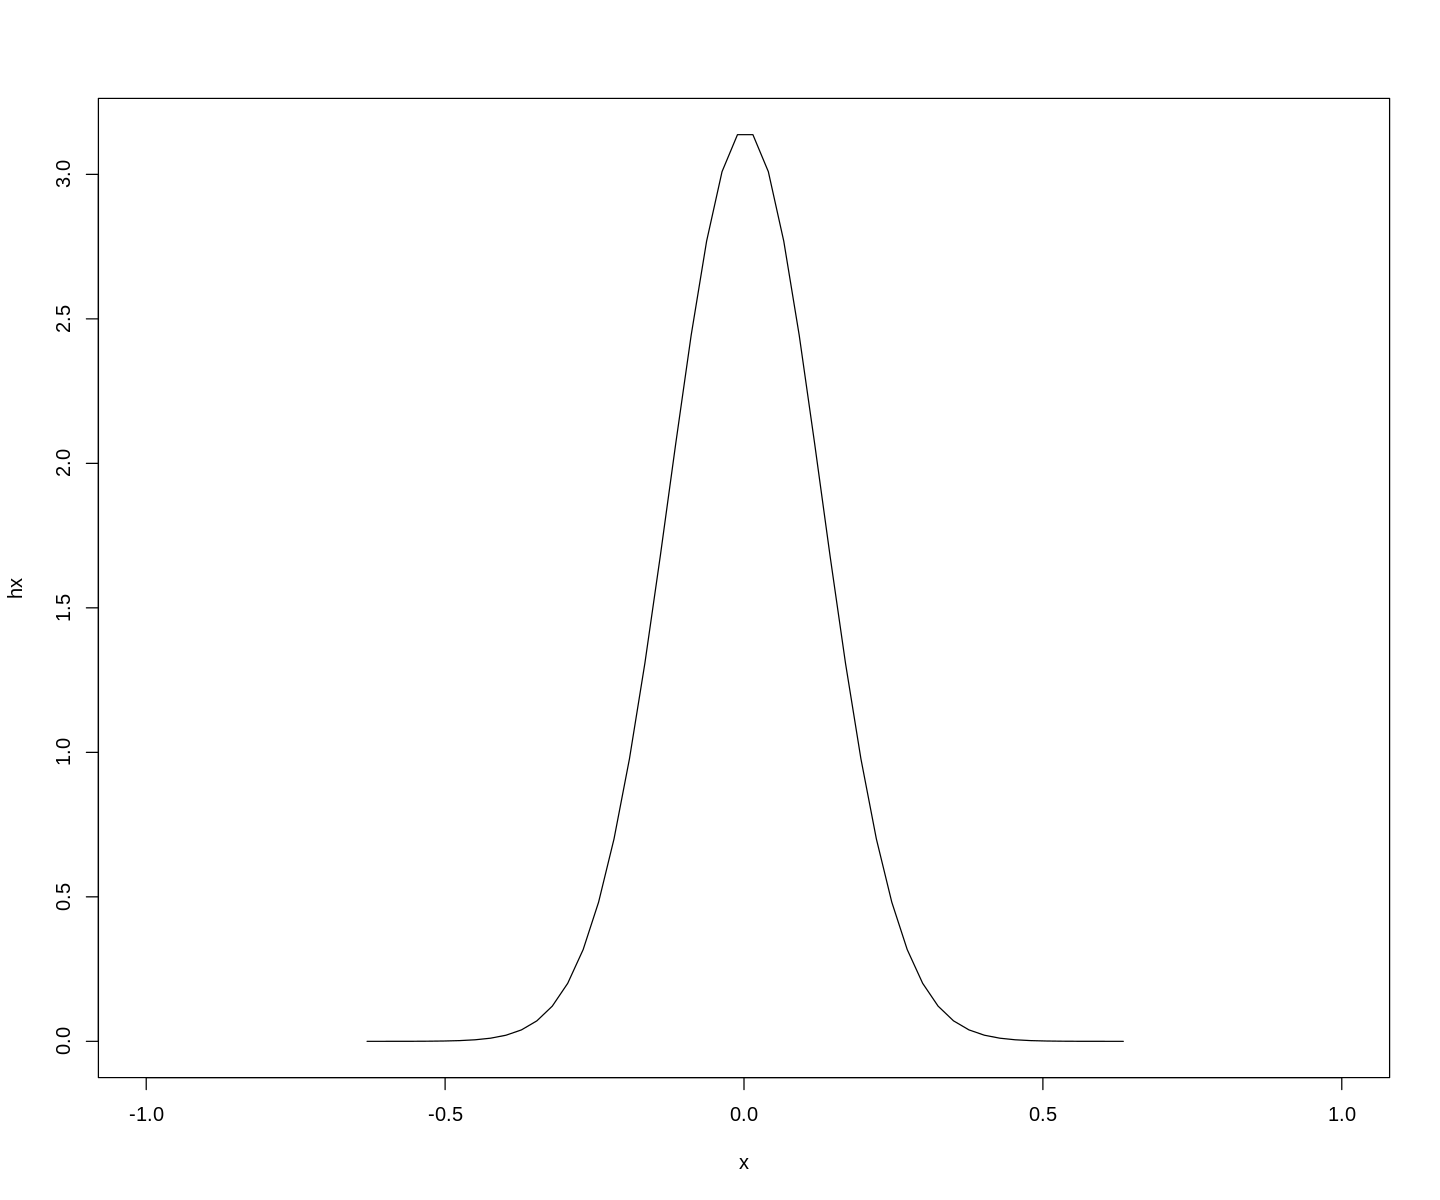

In [43]:
# Let's see i.e. 30-days returns of all trading systems after removing errors and outliers:

sql = str_interp("select Return030
       from SystemsReturnsInIntervals 
       where
         Date(DateStart) >= '2017-06-01' 
         and Equity030 is not null
         and systemid not in (select systemid from SystemsDataCleaner)")

dbData = getC2ScoreDbData(sql)    

cat("\nObservations:",nrow(dbData),"\n")
summary(dbData$Return030)
hist(dbData$Return030,breaks=50)

# Normal distribution with the same mean and standard deviation
mean = mean(dbData$Return030,na.rm = TRUE)
sd = sd(dbData$Return030,na.rm = TRUE)
x = seq(-5,5,length=50)*sd + mean; hx = dnorm(x,mean,sd);
plot(x, hx, type="l",xlim=c(-1,1))

Recall what we are looking at: This histogram represents hundreds thousands of 30 days returns observations of all Collective2 systems, day-by-day within the whole Collective2 history since 2017-06-01.

It seems data are approximately normally distributed.